# Fully Convolutional Watershed Distance Transform for 2D Data
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [1]:
import os
import errno

import numpy as np

import deepcell
from deepcell import model_zoo

### Load the Training Data

In [2]:
# create folder for this set of experiments
experiment_folder = "20191113_Decidua_Shirley_Relabel"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [3]:
npz_name = "Decidua_Caliban_V3_blanked_stride_0.5"
training_data = np.load(NPZ_DIR + npz_name +".npz")
(X_train, y_train) = training_data["X"], training_data["y"]

print('X_train.shape: {}\ny_train.shape: {}'.format(X_train.shape, y_train.shape))

X_train.shape: (1024, 256, 256, 6)
y_train.shape: (1024, 256, 256, 1)


### Set up filepath constants

In [4]:
# the path to the data file is currently required for `train_model_()` functions
DATA_FILE = os.path.join(NPZ_DIR, npz_name + ".npz")

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

### Set up training parameters

In [5]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

n_epoch = 3  # Number of training epochs
norm_method = 'std'  # data normalization
receptive_field = 101  # should be adjusted for the scale of the data
n_conv_filters = 128
n_dense_filters = 512
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
conv_model_name = npz_name + '_convolutional_watershed_{}_rf_{}_dense_{}_conv'.format(receptive_field, n_dense_filters, n_conv_filters)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)
test_size = 0.05
seed = 0
# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'watershed'
distance_bins = 4
erosion_width = 2  # erode edges, improves segmentation when cells are close

### Create a model for the watershed energy transform

#### Instantiate the distance transform model

In [6]:
watershed_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=None,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_conv_filters=n_conv_filters,
    n_dense_filters=n_dense_filters,
    last_only=False,
    input_shape=tuple(X_train.shape[1:]))

W0119 21:09:38.570274 140237821187904 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
conv_model_name

'Decidua_Caliban_V3_blanked_stride_0.5_convolutional_watershed_101_rf_512_dense_128_conv'

#### Train the distance transform model

In [8]:
from deepcell.training import train_model_conv

watershed_model = train_model_conv(
    model=watershed_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=conv_model_name,
    test_size=test_size,
    seed=seed,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    transform=transform,
    distance_bins=distance_bins,
    erosion_width=erosion_width,
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (972, 256, 256, 6)
y_train shape: (972, 256, 256, 1)
X_test shape: (52, 256, 256, 6)
y_test shape: (52, 256, 256, 1)
Output Shape: (None, 256, 256, 4)
Number of Classes: 4
Training on 1 GPUs
Epoch 1/3


W0119 21:10:53.814595 140237821187904 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


971/972 [============================>.] - ETA: 0s - loss: 4.3678 - model_loss: 1.0501 - model_1_loss: 1.0507 - model_2_loss: 1.0551 - model_3_loss: 1.0478 - model_acc: 0.6737 - model_1_acc: 0.6741 - model_2_acc: 0.6721 - model_3_acc: 0.6766
Epoch 00001: val_loss improved from inf to 4.18466, saving model to /data/models/20191113_Decidua_Shirley_Relabel/Decidua_Caliban_V3_blanked_stride_0.5_convolutional_watershed_101_rf_512_dense_128_conv.h5
972/972 [==============================] - 597s 614ms/step - loss: 4.3669 - model_loss: 1.0499 - model_1_loss: 1.0505 - model_2_loss: 1.0548 - model_3_loss: 1.0475 - model_acc: 0.6738 - model_1_acc: 0.6743 - model_2_acc: 0.6722 - model_3_acc: 0.6768 - val_loss: 4.1847 - val_model_loss: 1.0159 - val_model_1_loss: 0.9973 - val_model_2_loss: 0.9937 - val_model_3_loss: 1.0137 - val_model_acc: 0.7292 - val_model_1_acc: 0.7262 - val_model_2_acc: 0.7276 - val_model_3_acc: 0.7103
Epoch 2/3
971/972 [============================>.] - ETA: 0s - loss: 3.8984 

### Run the model

In [9]:
test_data = np.load(NPZ_DIR + "lab_combined_test_nolamin.npz")
(X_test, y_test) = test_data["X"], test_data["y"]

In [20]:
weights_path = os.path.join(MODEL_DIR, conv_model_name + "_epoch3.h5")
run_conv_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=None,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_conv_filters=64,
    n_dense_filters=256,
    last_only=False,
    input_shape=tuple(X_test.shape[1:]))

run_conv_model.load_weights(weights_path)

In [21]:
# make predictions on testing data
test_images = run_conv_model.predict(X_test[:1])[-1]

print('watershed transform shape:', test_images.shape)

watershed transform shape: (1, 1024, 1024, 4)


### Watershed post-processing

In [22]:
# Collapse predictions into semantic segmentation mask
argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

watershed argmax shape: (1, 1024, 1024, 1)


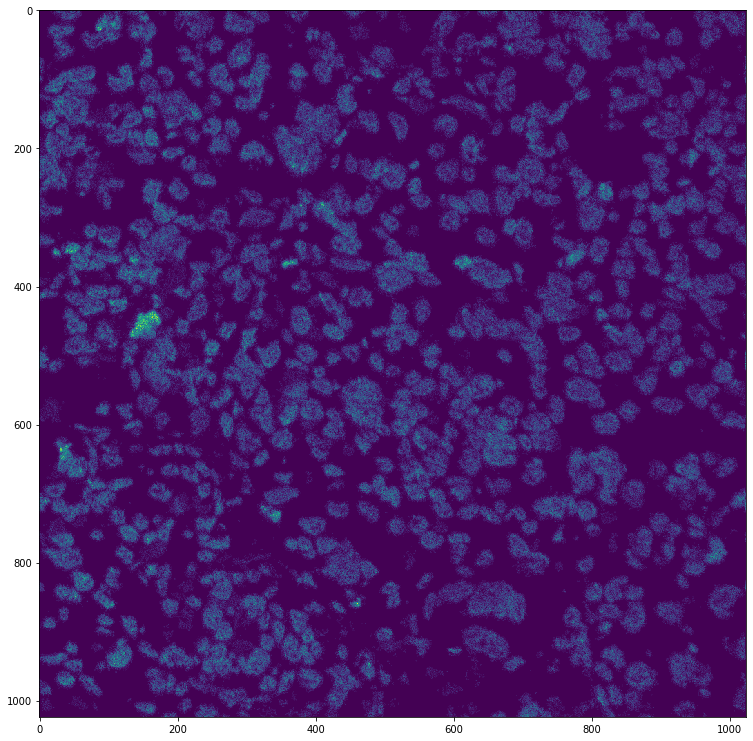

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(X_test[0, :, :, 0])

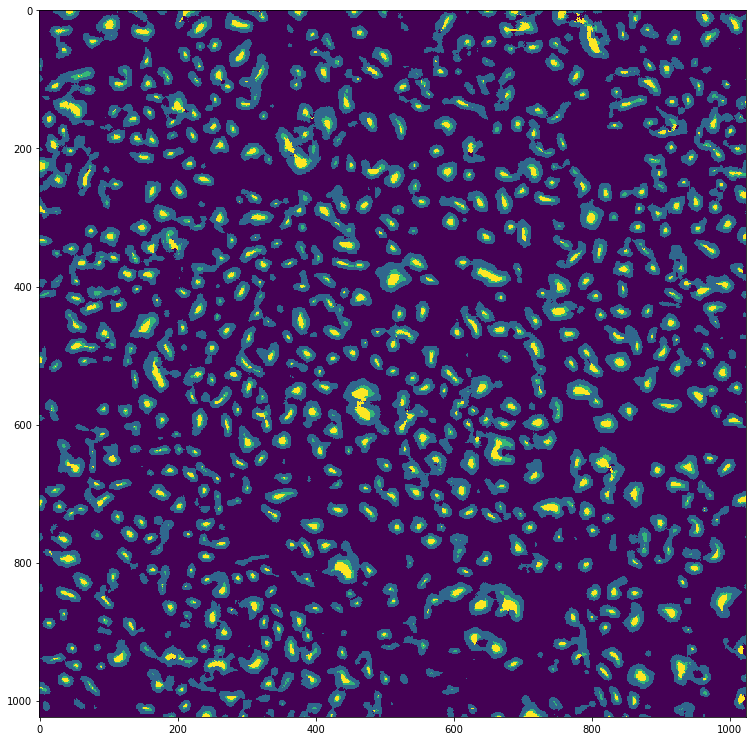

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[0, :, :, 0])

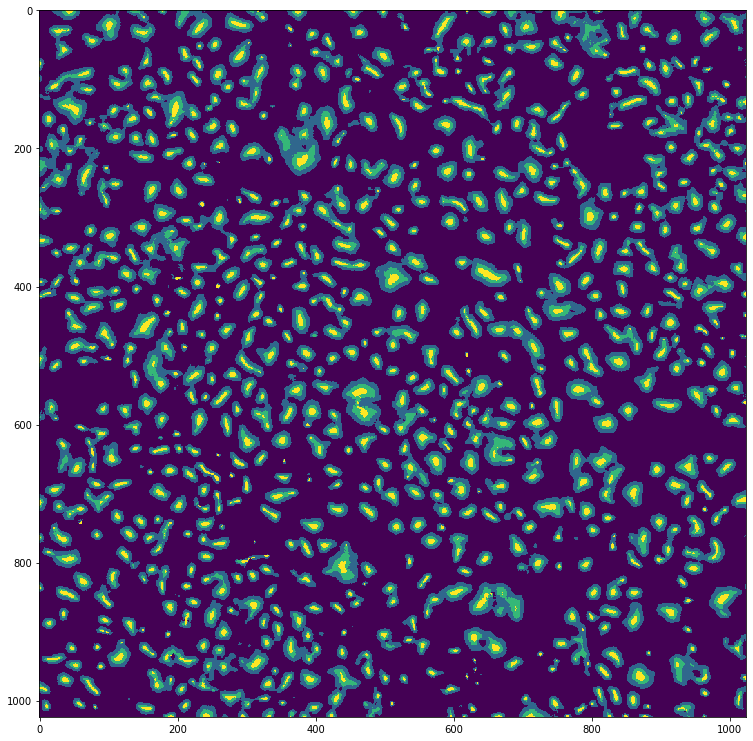

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[0, :, :, 0])

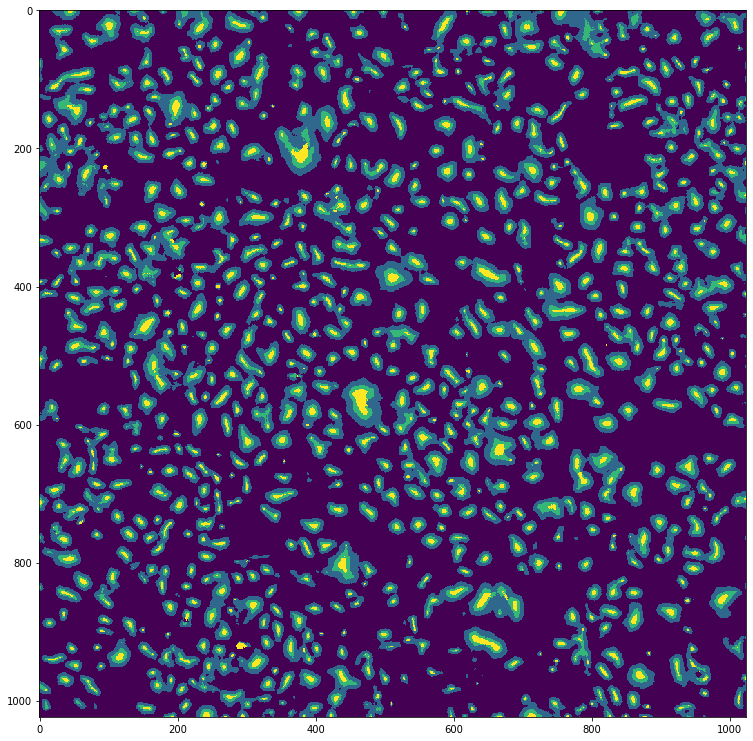

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[0, :, :, 0])